### For Exploratory Data Analysis, refer this notebook [Exploratory Data Analysis](./Exploratory-Data-Analysis.ipynb)

### For Machine Learning models implementation, refer this notebook [ML Models Implementation](./ML-Models-Implementation.ipynb)

# Importing Libraries

In [1]:
# data manipulation libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

# tensorflow imports
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import Dropout, Dense
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

# sklearn imports
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.model_selection import train_test_split 
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split, cross_val_score, RepeatedStratifiedKFold, cross_validate
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, \
f1_score, recall_score, roc_auc_score, precision_score, make_scorer

In [2]:
# constants to be used for word embedding model 

vocab_size = 10000
embedding_dim = 16
max_length = 500
trunc_type='post'
padding_type='post'
oov_tok = "<OOV>"
training_size = 35000

# Reading the clean data 

* reading the cleaned data from the saved files
* assigning them to their corresponding columns in the dataframe

In [3]:
with open('clean-dataset/corpus.txt', 'r', encoding='utf-8') as file:
    description = list(file.readlines())
    
with open('clean-dataset/final-categories.txt', 'rt') as file:
    primary_category = list(file.readlines())
    
df = pd.DataFrame()
df["description"] = description 
df["primary_category"] = primary_category
df["description"] = df["description"].str.replace('\n', '') 
df["primary_category"] = df["primary_category"].str.replace('\n', '')

df.head(3)

,description,primary_category
0,alisha solid woman cycling short cotton lycra ...,Clothing
1,fabhomedecor fabric double sofa bed finish col...,Furniture
2,belly sandal wedge heel casuals belly price ma...,Footwear


# Splitting the data into training and testing set

* Dividing the whole data into 80:20 ratio using train_test_split from sklearn

In [4]:
X = np.array(df["description"])
y = np.array(df["primary_category"])

training_sentences, testing_sentences, training_labels, testing_labels = train_test_split(X, y, test_size=0.20, random_state=73)

print(training_sentences.shape)
print(testing_sentences.shape)
print(training_labels.shape)
print(testing_labels.shape)

(15732,)
(3934,)
(15732,)
(3934,)


# Converting Labels using Label Encoder

* Text is not accepted as labels in deep learning models 
* So, we have to transform the training and testing labels using Label Encoder

In [5]:
le = LabelEncoder()
training_labels = le.fit_transform(training_labels)

training_labels

array([ 3, 20,  5, ..., 13, 26, 17])

In [6]:
testing_labels = le.transform(testing_labels)

testing_labels

array([17,  6,  3, ..., 24, 17, 13])

# Feature Extraction Functions

* Count Vectorizer
* TF-IDF Vectorizer
* Pipeline of Count Vectorizer followed by TF-IDF Vectorizer followed by the model

In [7]:
# returns X_train_features and X_test_features after applying CountVectorizer on both 

def CountVec(X_train, X_test):
    count_vec = CountVectorizer()
    X_train_features = count_vec.fit_transform(X_train).toarray()
    X_test_features = count_vec.transform(X_test).toarray()
    return (X_train_features, X_test_features)

In [8]:
# returns X_train_features and X_test_features after applying TFIDFVectorizer on both 

def TFIDF(X_train, X_test):
    tfidf_vec = TfidfVectorizer()
    X_train_features = tfidf_vec.fit_transform(X_train).toarray()
    X_test_features = tfidf_vec.transform(X_test).toarray()
    return (X_train_features, X_test_features)

# Plot history function 

* plot accuracy against no of epocs for trained deep learning model
* plot loss against no of epocs for trained deep learning model

In [9]:
# summarize history for accuracy & loss

def plot_history(history):
    fig, axes = plt.subplots(nrows=1, ncols=2) 
    
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    
    fig.tight_layout()
    plt.show()

# Dense Neural Network with Text Embedding

In [10]:
# converting text to sequences using tokenizer

tokenizer = Tokenizer(num_words=vocab_size, oov_token=oov_tok)
tokenizer.fit_on_texts(training_sentences)

word_index = tokenizer.word_index

training_sequences = tokenizer.texts_to_sequences(training_sentences)
training_padded = pad_sequences(training_sequences, maxlen=max_length, padding=padding_type, truncating=trunc_type)

testing_sequences = tokenizer.texts_to_sequences(testing_sentences)
testing_padded = pad_sequences(testing_sequences, maxlen=max_length, padding=padding_type, truncating=trunc_type)

In [11]:
print(len(training_sequences))
print(training_padded)

15732
[[1940  232 2460 ...    0    0    0]
 [  13    1  728 ...    0    0    0]
 [2599   10  184 ...    0    0    0]
 ...
 [2766  401  223 ...    0    0    0]
 [ 975  126   94 ...    0    0    0]
 [ 233   58   24 ...    0    0    0]]


In [12]:
# converting to numpy arrays

training_padded = np.array(training_padded)
training_labels = np.array(training_labels)
testing_padded = np.array(testing_padded)
testing_labels = np.array(testing_labels)

In [13]:
# building the model 

model = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size, embedding_dim, input_length=max_length),
    tf.keras.layers.GlobalAveragePooling1D(),
    tf.keras.layers.Dense(24, activation='relu'),
    tf.keras.layers.Dense(28, activation='softmax')
])
model.compile(loss='sparse_categorical_crossentropy',
                  optimizer='adam',
                  metrics=['accuracy'])

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 500, 16)           160000    
_________________________________________________________________
global_average_pooling1d (Gl (None, 16)                0         
_________________________________________________________________
dense (Dense)                (None, 24)                408       
_________________________________________________________________
dense_1 (Dense)              (None, 28)                700       
Total params: 161,108
Trainable params: 161,108
Non-trainable params: 0
_________________________________________________________________


In [14]:
# training the model

num_epochs = 50
history = model.fit(training_padded, training_labels, epochs=num_epochs, 
                    validation_data=(testing_padded, testing_labels), verbose=2)

# model.save('trained-models/DNN-WordEmbeddings.pkl')

# model = tf.keras.models.load_model('trained-models/DNN-WordEmbeddings.pkl')

Epoch 1/50
492/492 - 3s - loss: 2.5671 - accuracy: 0.3134 - val_loss: 2.4075 - val_accuracy: 0.3096
Epoch 2/50
492/492 - 2s - loss: 2.3021 - accuracy: 0.3180 - val_loss: 2.2394 - val_accuracy: 0.3208
Epoch 3/50
492/492 - 2s - loss: 1.9360 - accuracy: 0.4726 - val_loss: 1.7506 - val_accuracy: 0.5236
Epoch 4/50
492/492 - 2s - loss: 1.5449 - accuracy: 0.5567 - val_loss: 1.4696 - val_accuracy: 0.5722
Epoch 5/50
492/492 - 2s - loss: 1.3275 - accuracy: 0.6278 - val_loss: 1.3064 - val_accuracy: 0.6418
Epoch 6/50
492/492 - 2s - loss: 1.1967 - accuracy: 0.6616 - val_loss: 1.2042 - val_accuracy: 0.6566
Epoch 7/50
492/492 - 2s - loss: 1.1052 - accuracy: 0.6771 - val_loss: 1.1245 - val_accuracy: 0.6787
Epoch 8/50
492/492 - 2s - loss: 1.0271 - accuracy: 0.7046 - val_loss: 1.0544 - val_accuracy: 0.7150
Epoch 9/50
492/492 - 2s - loss: 0.9529 - accuracy: 0.7286 - val_loss: 0.9847 - val_accuracy: 0.7196
Epoch 10/50
492/492 - 2s - loss: 0.8806 - accuracy: 0.7630 - val_loss: 0.9204 - val_accuracy: 0.7697

In [15]:
# predictions

predicted_labels = model.predict_classes(testing_padded)

print(accuracy_score(testing_labels, predicted_labels))
# print(classification_report(testing_labels, predicted))
# print(confusion_matrix(testing_labels, predicted))

C:\Users\kusha\anaconda3\lib\site-packages\tensorflow\python\keras\engine\sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


0.9476359938993391


In [16]:
# training predictions

training_predicted_labels = model.predict_classes(training_padded)

print(accuracy_score(training_labels, training_predicted_labels))

0.9837274345283499


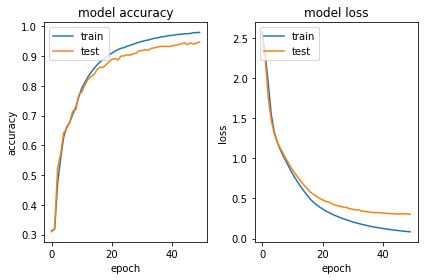

In [17]:
# plotting the accuracy and loss graphs for the above model

plot_history(history)

# DNN using Text Vectorization (Count Vec / TF-IDF)

In [18]:
# Build Deep neural networks Model for text classification
# Shape is input feature space
# n_classes is number of unqiue classes


def Build_DNN_Model_Text(shape, n_classes, dropout=0.5):
    model = Sequential()
    node = 512 # number of nodes
    n_layers = 4 # number of  hidden layers
    model.add(Dense(node, input_dim=shape, activation='relu'))
    model.add(Dropout(dropout))
    for i in range(0, n_layers):
        model.add(Dense(node, input_dim=node, activation='relu'))
        model.add(Dropout(dropout))
        
    model.add(Dense(n_classes, activation='softmax'))
    model.compile(loss='sparse_categorical_crossentropy',
                  optimizer='adam',
                  metrics=['accuracy'])
    return model

X_train_features, X_test_features = CountVec(training_sentences, testing_sentences)
# X_train_features, X_test_features = TFIDF(training_sentences, testing_sentences)

model_DNN = Build_DNN_Model_Text(X_train_features.shape[1], 28)
print(model.summary())

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 500, 16)           160000    
_________________________________________________________________
global_average_pooling1d (Gl (None, 16)                0         
_________________________________________________________________
dense (Dense)                (None, 24)                408       
_________________________________________________________________
dense_1 (Dense)              (None, 28)                700       
Total params: 161,108
Trainable params: 161,108
Non-trainable params: 0
_________________________________________________________________
None


In [19]:
# training the model 

history = model_DNN.fit(X_train_features, training_labels,
                              validation_data=(X_test_features, testing_labels),
                              epochs=15,
                              batch_size=128,
                              verbose=2)

# model_DNN.save('trained-models/DNN-countvec.pkl')
# model_DNN = tf.keras.models.load_model('trained-models/DNN-countvec.pkl')

# model_DNN.save('trained-models/DNN-tfidf.pkl')
# model_DNN = tf.keras.models.load_model('trained-models/DNN-tfidf.pkl')

Epoch 1/15
123/123 - 14s - loss: 1.5021 - accuracy: 0.5605 - val_loss: 0.6825 - val_accuracy: 0.8109
Epoch 2/15
123/123 - 13s - loss: 0.5352 - accuracy: 0.8495 - val_loss: 0.3502 - val_accuracy: 0.9039
Epoch 3/15
123/123 - 11s - loss: 0.3010 - accuracy: 0.9144 - val_loss: 0.2683 - val_accuracy: 0.9319
Epoch 4/15
123/123 - 11s - loss: 0.2108 - accuracy: 0.9395 - val_loss: 0.2312 - val_accuracy: 0.9479
Epoch 5/15
123/123 - 14s - loss: 0.1535 - accuracy: 0.9566 - val_loss: 0.2548 - val_accuracy: 0.9593
Epoch 6/15
123/123 - 12s - loss: 0.1281 - accuracy: 0.9640 - val_loss: 0.2253 - val_accuracy: 0.9629
Epoch 7/15
123/123 - 12s - loss: 0.1071 - accuracy: 0.9697 - val_loss: 0.2302 - val_accuracy: 0.9675
Epoch 8/15
123/123 - 12s - loss: 0.0900 - accuracy: 0.9753 - val_loss: 0.2214 - val_accuracy: 0.9654
Epoch 9/15
123/123 - 11s - loss: 0.0955 - accuracy: 0.9767 - val_loss: 0.1953 - val_accuracy: 0.9642
Epoch 10/15
123/123 - 12s - loss: 0.0822 - accuracy: 0.9797 - val_loss: 0.2079 - val_accura

In [20]:
# predictions

predicted_labels = model_DNN.predict_classes(X_test_features)

print(accuracy_score(testing_labels, predicted_labels))
# print(classification_report(testing_labels, predicted))
# print(confusion_matrix(testing_labels, predicted))

0.9738179969496695


In [21]:
# training predictions

training_predicted_labels = model_DNN.predict_classes(X_train_features)

print(accuracy_score(training_labels, training_predicted_labels))

0.9960589880498347


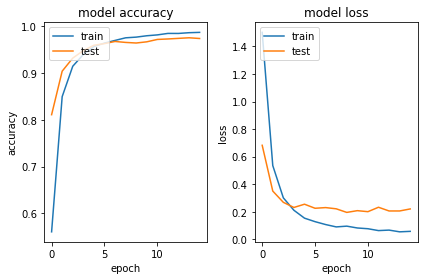

In [22]:
# plotting the accuracy and loss graphs for the above model

plot_history(history)